In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pandas as pd

# Load Dataset

In [2]:
def load_data():

    df = pd.read_csv("train.csv")
    y = df[['label']].to_numpy() 
    # x = df.loc[:, df.columns != 'label']
    X = df.drop('label', axis=1).to_numpy()    
    
#     X = np.load("data/X.npy")
#     y = np.load("data/y.npy")
    return split_data(X, y)

def split_data(X, y, train_size = 0.7):
    """
    Return a dictionary containing the traning set, validation set and the test set
    """
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5)
    data = {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)}
    return data

In [3]:
data = load_data()

In [4]:
print("X_train shape is {}".format(data['train'][0].shape))
print("y_train shape is {}".format(data['train'][1].shape))
print("X_val shape is {}".format(data['val'][0].shape))
print("y_val shape is {}".format(data['val'][1].shape))
print("X_test shape is {}".format(data['test'][0].shape))
print("y_test shape is {}".format(data['test'][1].shape))

X_train shape is (29399, 784)
y_train shape is (29399, 1)
X_val shape is (6300, 784)
y_val shape is (6300, 1)
X_test shape is (6301, 784)
y_test shape is (6301, 1)


# Methods for KMeans Algorithm

In [5]:
def kmeans_init_centroids(X, K):
    """
    Initialize K centroids for KNN algorithm
    Args:
        X (ndarray): feature value of each example
        K (int): number of centroids  
    Returns:
        centroids (ndarray): initialized feature values of k centroids
    """
    
    # Randomly shuffles the indices of the examples
    random_idx = np.random.permutation(X.shape[0])
    # Using the first K elements as initial centroids
    centroids = X[random_idx[:K]]
    
    return centroids

In [6]:
def closest_centroids(X, centroids):
    """
    Find the indices of the closest centroid for each example
    Args:
        X (ndarray shape (m, n)): feature value of each example
        centroids (ndarray): feature value of each centroid
    Returns:
        idx (array): array of ints, idx[i] = j means the closest centroid for ith example is the jth centroid.          
    """
    
    # Get number of examples and number of features
    m, n = X.shape
    # Get number of centroids
    K = centroids.shape[0]
    # Create an np array where each index indicates which centroid the example belongs to
    idx = np.zeros(m, dtype=int)
    
    for i in range(m):
        # X[i] shape (1, n), centroids shape (k, n)
        # X[i] - centroids will gives us a K * n matrix and then setting axis = 1 will find the euclidean distance
        # of the numbers in each row. Output is (K,) array contains the distance of X[i] to each of the centroids.
        distance = np.linalg.norm((X[i] - centroids), axis = 1)
        # Store the distance of the closest centroid to the ith example
        idx[i] = np.argmin(distance, axis = 0)
        
    return idx

In [7]:
def reassign_centroids(X, idx, K):
    """
    Reassign the feature values of the centroids by calculating the mean of each data points assigned to each centroid
    Args:
        X (ndarray shape (m, n)): feature value of each example
        idx (array): array of ints, idx[i] = j means the closest centroid for ith example is the jth centroid.          
        K (int): number of centroids
    Returns:
        centroids (ndarray shape (K, n)): feature values of the reassigned k centroids 
    """
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    for i in range(K):
        # Get the data points belong to centroid i
        points = X[idx == i]
        centroids[i] = np.mean(points, axis = 0) 

    return centroids

In [8]:
def run_kmeans(X, init_centroids, max_iters=20):
    """
    Run the KNN algorithm
    Args: 
        X (ndarray shape (m, n)): feature value of each example
        init_centroids (ndarray): initialized feature values of k centroids
        max_iters (int): number of iterations to run knn
    Returns:
        centroids (ndarray shape (K, n)): feature values of the k centroids 
        idx (array): array of ints, idx[i] = j means the closest centroid for ith example is the jth centroid.          
    """
    
    m, n = X.shape
    K = init_centroids.shape[0]
    centroids = init_centroids
    idx = np.zeros(m)
    
    for i in range(max_iters):  
        # find the closest centroid of each example
        idx = closest_centroids(X, centroids)
        # reassign the feature values for each centroid
        centroids = reassign_centroids(X, idx, K)
        
    return centroids, idx

In [9]:
def predict(X, y, centroids, idx):
    """
    Predict the target value of each centroid and target value of their neighbor data points
    Args:
        X (ndarray shape (m, n)): feature value of each example
        y (ndarray shape (m, 1)): target value of each example
        centroids (ndarray shape (K, n)): feature values of the k centroids 
        idx (array): array of ints, idx[i] = j means the closest centroid for ith example is the jth centroid.          
    Returns:
        prediction (ndarray shape (K,)): the predicted value for the neighbors of each centroid
    """
    
    m, n = X.shape
    K = centroids.shape[0]
    # find the unique values in y 
    classes = np.unique(data['train'][1])
    prediction = np.zeros(K, dtype=int)
    
    for i in range(K):
        # get all the data points that are neighbors of centroid[i]
        neighbor = X[idx == i]
        # get the target value of those data points neighboring centroids[i]
        label = y[idx == i]
        
        # lebel == classes will result in a matrix where there are 10 columns, since there are 10 unique numbers in y.
        # Get the number of element equal to 0-9 respectively, and dividing them by the number of examples 
        # will gives us the probabilities of the centroid belong to class 0-9. 
        # If pred[4] has the highest probability that means the predicted value for all neighbors of centroid i is 5
        
        # sometime a centroid would not have any neighbor, so label.shape[0] might be 0 and cause divide by 0 error
        # ignore this case
        np.seterr(divide='ignore', invalid='ignore')
        pred = np.sum(label == classes, axis = 0) / label.shape[0]
        np.seterr(divide='warn', invalid='warn')
        # find the class with the highest probability
        prediction[i] = classes[np.argmax(pred)]
    
    return prediction

In [10]:
# example
centroids = kmeans_init_centroids(data['train'][0], 10)
idx = closest_centroids(data['train'][0], centroids)
label = data['train'][1][idx == 1]
classes = np.unique(data['train'][1])
print("Number of elements belong to class 0-9:" + str(np.sum(label == classes, axis = 0)))
pred = np.sum(label == classes, axis = 0) / label.shape[0]
print("Probability of the centroid belong to class 0-9: \n" + str(pred))
print("The predicted value for all neighbors of the centroid is " + str(classes[np.argmax(pred)]))

Number of elements belong to class 0-9:[196   1  18 178   0 244  12   8 191   9]
Probability of the centroid belong to class 0-9: 
[0.22870478 0.00116686 0.0210035  0.20770128 0.         0.28471412
 0.01400233 0.00933489 0.22287048 0.01050175]
The predicted value for all neighbors of the centroid is 5


## Fine Tuning

In [11]:
def optimal(data, K, max_iter):
    """
    Find the optimal number of centroids and number of iterations to fit the training set and print out the 
    optimal hyperparamters and best accuracies
    Args:
        data (Dict): contains the training, validation and test dataset
        K (int): number of centroids
        max_iter: number of iterations to run the KNN algorithem
    Returns:
        y_pred_test (ndarray): the predicted value for each example in the test set
    """
    
    m_train, n_train = data['train'][0].shape
    m_val, n_val = data['val'][0].shape
    m_test, n_test = data['test'][0].shape
    best_k = 0
    best_iter = 0
    best_val_acc = 0
    best_train_acc = 0
    best_centroids = np.array([])
    
    for k in K:
        for i in max_iter:
            # random inital centroids might result in different clusters, so you can run the process multiple times and 
            # choose the best centroids
            for _ in range(2):
                # run KNN algorithm on training set, and get the prediction
                init_centroids = kmeans_init_centroids(data['train'][0], k)
                centroids, idx = run_kmeans(data['train'][0], init_centroids, i)
                prediction = predict(data['train'][0], data['train'][1], centroids, idx)

                # get the prediction for validation set
                valid_idx = closest_centroids(data['val'][0], centroids)
                prediction_val = predict(data['val'][0], data['val'][1], centroids, valid_idx)

                # prediction[idx] will result in a (m,) array where each value is the predicted value of each example
                y_pred = prediction[idx].reshape(m_train, -1) 
                acc = np.sum(y_pred == data['train'][1]) / m_train

                y_pred_val = prediction_val[valid_idx].reshape(m_val, -1)
                acc_val = np.sum(y_pred_val == data['val'][1]) / m_val

                print("training set, k: {}, max_iter: {}, accuracy: {}".format(k, i, acc))
                print("validation set, k: {}, max_iter: {}, accuracy: {}".format(k, i, acc_val))

                if best_val_acc < acc_val:
                    best_val_acc = acc_val
                    best_k = k
                    best_iter = i
                    best_train_acc = acc
                    best_centroids = centroids
                
    print("best_k: {}, best_max_iter: {}".format(best_k, best_iter))
    print("training set accuracy: {}".format(best_train_acc))
    print("validation set accuracy: {}".format(best_val_acc))
    
    test_idx = closest_centroids(data['test'][0], best_centroids)
    prediction = predict(data['test'][0], data['test'][1], best_centroids, test_idx)
    y_pred_test = prediction[test_idx].reshape(m_test, -1)
    test_acc = np.sum(y_pred_test == data['test'][1]) / m_test
    print("test set accuracy: {}".format(test_acc))
    return y_pred_test

In [12]:
K = [10, 30, 60]
max_iter = [10, 20, 30]
y_pred_test = optimal(data, K, max_iter)

training set, k: 10, max_iter: 10, accuracy: 0.575325691350046
validation set, k: 10, max_iter: 10, accuracy: 0.5787301587301588
training set, k: 10, max_iter: 10, accuracy: 0.5749175142011633
validation set, k: 10, max_iter: 10, accuracy: 0.5798412698412698
training set, k: 10, max_iter: 20, accuracy: 0.5888975815503928
validation set, k: 10, max_iter: 20, accuracy: 0.5893650793650793
training set, k: 10, max_iter: 20, accuracy: 0.6014830436409402
validation set, k: 10, max_iter: 20, accuracy: 0.6073015873015873
training set, k: 10, max_iter: 30, accuracy: 0.5970611245280452
validation set, k: 10, max_iter: 30, accuracy: 0.5952380952380952
training set, k: 10, max_iter: 30, accuracy: 0.5985577740739481
validation set, k: 10, max_iter: 30, accuracy: 0.6041269841269842
training set, k: 30, max_iter: 10, accuracy: 0.7310792884111704
validation set, k: 30, max_iter: 10, accuracy: 0.7414285714285714
training set, k: 30, max_iter: 10, accuracy: 0.7432565733528351
validation set, k: 30, max_

# Exmaples

## Wrong Prediction

In [13]:
X_test, y_test = data['test']

In [14]:
print("{} error out of {} image in test set".format(sum(y_pred_test != y_test)[0],  X_test.shape[0]))

1034 error out of 6301 image in test set


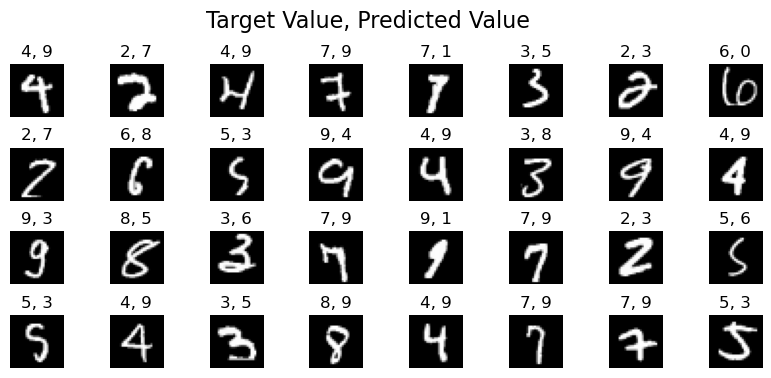

In [15]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X_test.shape
idxs = np.where(y_pred_test != y_test)[0] # get the indices where the target value is different from the predicted value

# Create subsplots for each of the falsely predicted elements
fig, axes = plt.subplots(4, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.5, 1, 0.92]) #[left, bottom, right, top]

# axes is a 8 by 8 np array
for i, ax in enumerate(axes.flat): 
    # Select the indices of wrong predictions
    i_wrong_pred = idxs[i]
    # Select examples corresponding to the indices of wrong predictions and reshape the image
    X_wrong_pred = X_test[i_wrong_pred].reshape((28, 28))
    
    # Display the image
    ax.imshow(X_wrong_pred, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y_test[i_wrong_pred, 0]}, {y_pred_test[i_wrong_pred, 0]}")
    # disable the axis
    ax.set_axis_off() 
fig.suptitle("Target Value, Predicted Value", fontsize=16)
plt.show()

## Correct Predictions

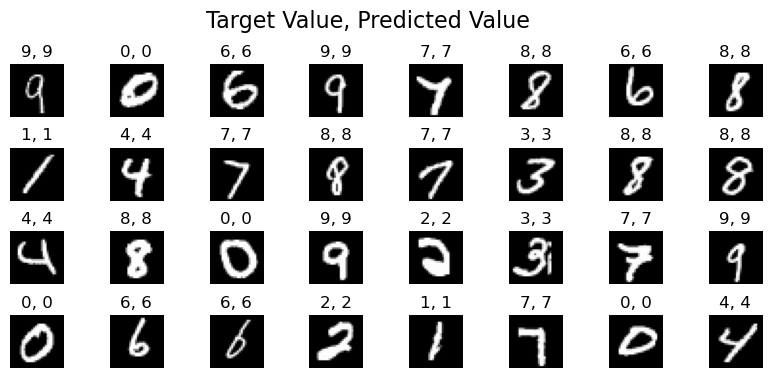

In [16]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

X_test, y_test = data['test']
m, n = X_test.shape
idxs = np.where(y_pred_test == y_test)[0] # get the indices where the target value is different from the predicted value

# Create subsplots for each of the falsely predicted elements
fig, axes = plt.subplots(4, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.5, 1, 0.92]) #[left, bottom, right, top]

# axes is a 8 by 8 np array
for i, ax in enumerate(axes.flat): 
    # Select the indices of wrong predictions
    i_wrong_pred = idxs[i]
    # Select examples corresponding to the indices of wrong predictions and reshape the image
    X_wrong_pred = X_test[i_wrong_pred].reshape((28, 28))
    
    # Display the image
    ax.imshow(X_wrong_pred, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y_test[i_wrong_pred, 0]}, {y_pred_test[i_wrong_pred, 0]}")
    # disable the axis
    ax.set_axis_off() 
fig.suptitle("Target Value, Predicted Value", fontsize=16)
plt.show()